In [1]:
import torch
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

from src.utils import get_data

raw_train_path = "data/release_train_data.json"
raw_test_path = "data/phase_1_test.json"

In [2]:
with open(f"{raw_train_path}", "r") as json_file:
    raw_train_data = json.load(json_file)
    
with open(f"{raw_test_path}", "r") as json_file:
    raw_test_data = json.load(json_file)

print(len(raw_train_data))
print(len(raw_test_data))

12557
1794


num_of_history per QA: 
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 250, 2219, 7013, 2697,  349,   24,    3,    2]))
num_of_document per QA: 
(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 25, 27, 44]), array([1330, 1011,  801,  720, 8641,   37,    9,    2,    1,    2,    1,
          1,    1]))


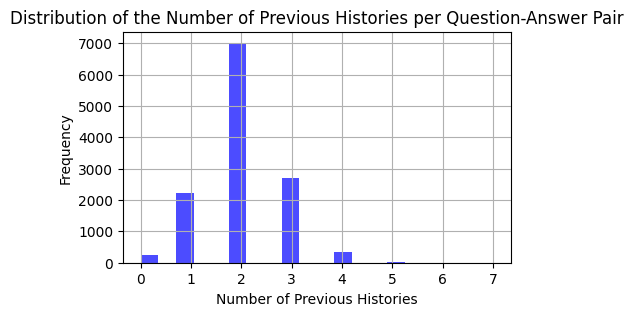

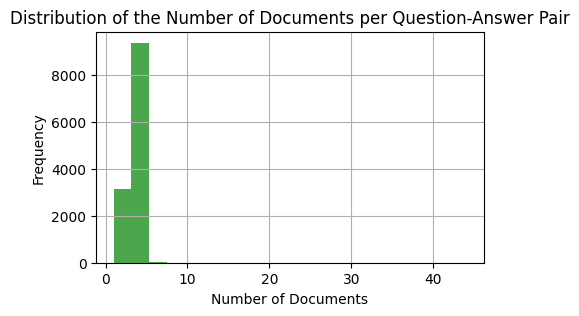

In [3]:
num_of_history_per_qa = []
num_of_doc_per_qa = []

for data in raw_train_data:
    num_of_history_per_qa.append(len(data['history']))
    num_of_doc_per_qa.append(len(data['documents']))

print(f"num_of_history per QA: ")
print(np.unique(num_of_history_per_qa,return_counts=True))

print(f"num_of_document per QA: ")
print(np.unique(num_of_doc_per_qa,return_counts=True))


# Histogram for the number of previous histories per question-answer pair
plt.figure(figsize=(5, 3))
plt.hist(num_of_history_per_qa, bins=20, color='blue', alpha=0.7)
plt.title('Distribution of the Number of Previous Histories per Question-Answer Pair')
plt.xlabel('Number of Previous Histories')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Histogram for the number of documents per question-answer pair
plt.figure(figsize=(5, 3))
plt.hist(num_of_doc_per_qa, bins=20, color='green', alpha=0.7)
plt.title('Distribution of the Number of Documents per Question-Answer Pair')
plt.xlabel('Number of Documents')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

num_of_history per QA: 
(array([0, 1, 2, 3, 4, 5, 7]), array([ 42, 319, 953, 425,  48,   6,   1]))
num_of_document per QA: 
(array([ 1,  2,  3,  4,  5,  6,  7,  9, 13, 14]), array([ 180,  116,   92,   97, 1297,    7,    1,    2,    1,    1]))


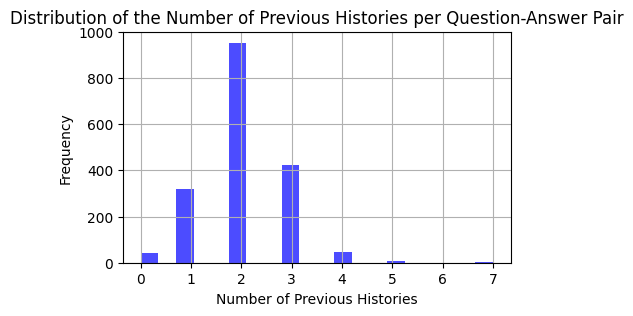

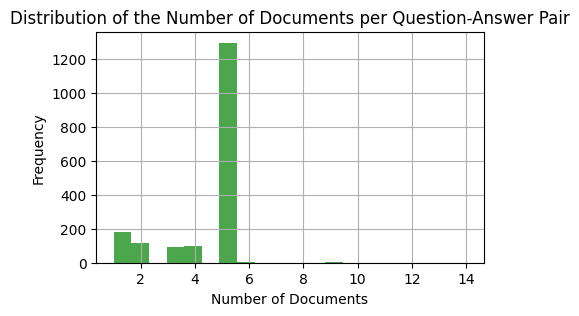

In [4]:
num_of_history_per_qa = []
num_of_doc_per_qa = []

for data in raw_test_data:
    num_of_history_per_qa.append(len(data['history']))
    num_of_doc_per_qa.append(len(data['documents']))

print(f"num_of_history per QA: ")
print(np.unique(num_of_history_per_qa,return_counts=True))

print(f"num_of_document per QA: ")
print(np.unique(num_of_doc_per_qa,return_counts=True))


# Histogram for the number of previous histories per question-answer pair
plt.figure(figsize=(5, 3))
plt.hist(num_of_history_per_qa, bins=20, color='blue', alpha=0.7)
plt.title('Distribution of the Number of Previous Histories per Question-Answer Pair')
plt.xlabel('Number of Previous Histories')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Histogram for the number of documents per question-answer pair
plt.figure(figsize=(5, 3))
plt.hist(num_of_doc_per_qa, bins=20, color='green', alpha=0.7)
plt.title('Distribution of the Number of Documents per Question-Answer Pair')
plt.xlabel('Number of Documents')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [5]:
import random

data = random.sample(raw_train_data,1)[0]

if True:
    print("========= history =========")
    for his in data['history']:
        print(f"Q: {his['question']}")
        print(f"A: {his['answer']}")
    print("===========================")
    
    print("========= history =========")
    for i,doc in enumerate(data['documents']):
        print(f"------{i}------")
        print(f"{doc}")
    print("===========================")
    
    print(f"Q: {data['question']}")
    print(f"A: {data['answer']}")


========= history =========
Q: What is comic con cos usually called?
A: Comic con cos is usually called Cosplay, which is a concept from Japan, an abbreviation of Costume Play, directly translated as role-playing.
========= history =========
------0------
If there are female babies who want to cos male characters, don't miss this video[Blowing KissR]
------1------
Because Haimeng is a coser, let her share some small cases of cos ~
	
cos for ten years, share some of my recommendations
Facial cleanser: Three parts delusion.
There is a 🪝 on the front, afraid of violations didn't shoot hhh, characters that can show 🪝 can also use ~
	
Questions about cosplay can be left in the comment area
------2------
1️⃣Find a character that you like and suits you, purchase the character's cosplay costume
🔷The purchase of COS clothes should go to quality, well-made C clothes shop; can find in certain treasure, certain pinduoduo
🔷COS clothing includes: character clothing, character wig, character props, b

In [6]:
#data = random.sample(raw_train_data,1)[0]
from transformers import AutoTokenizer
from tqdm import tqdm

tokenizer = AutoTokenizer.from_pretrained("t5-base")

history_len_sum_per_q = [] #question당 history(Q+A) 토큰 길이 전체 합 [# of data]
document_len_sum_per_q = [] #question당 document 토큰 길이 전체 합 [# of data]
all_len_sum_per_q = [] #question당 전체 토큰 길이 합 [# of data]
history_len_per_q = [] #question마다의 history 각 토큰들 개수  [# of data, # of history]
document_len_per_q = [] #question마다의 document 각 토큰들 개수  [# of data, # of document]
num_of_history = [] #question당 history 개수 [# of data]
num_of_doc = [] #question당 document개수 [# of data]

for x, data in tqdm(enumerate(raw_train_data)):
    concat_his = ""
    concat_doc = ""
    concat_all = ""

    history_len_per_q.append([])
    document_len_per_q.append([])
        
    for his in data['history']:
        concat_his += (his['question'] + his['answer'])
        concat_all += (his['question'] + his['answer'])  
        history_len_per_q[x].append(len(tokenizer.tokenize((his['question'] + his['answer']))))
    num_of_history.append(len(data['history']))
    
    for i,doc in enumerate(data['documents']):
        concat_doc += doc
        concat_all += doc
        document_len_per_q[x].append(len(tokenizer.tokenize(doc)))
    num_of_doc.append(len(data['documents']))
        
    concat_all += data['question']

    history_len_sum_per_q.append(len(tokenizer.tokenize(concat_his)))
    document_len_sum_per_q.append(len(tokenizer.tokenize(concat_doc)))
    all_len_sum_per_q.append(len(tokenizer.tokenize(concat_all)))
    
#print(concat_his)
#print(concat_doc)
#print(concat_all)

/home/tako/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/tako/.local/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5_fast.py:160: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
0it [00:00, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (694 > 512). Running this sequence through the model will result in indexing errors
12557it [01:28, 141.98it/s]


/home/tako/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tako/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Figure size 1200x800 with 0 Axes>

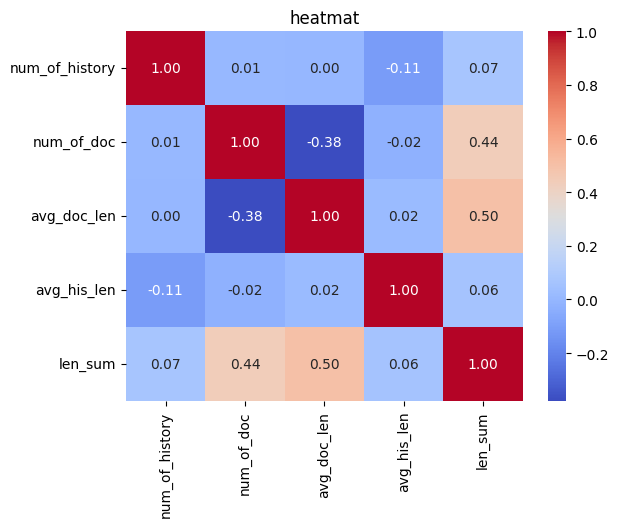

<Figure size 1200x800 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns


#history_len_sum_per_q = [] #question당 history(Q+A) 토큰 길이 전체 합 [# of data]
#document_len_sum_per_q = [] #question당 document 토큰 길이 전체 합 [# of data]
#all_len_sum_per_q = [] #question당 전체 토큰 길이 합 [# of data]
#history_len_per_q = [] #question마다의 history 각 토큰들 개수  [# of data, # of history]
#document_len_per_q = [] #question마다의 document 각 토큰들 개수  [# of data, # of document]
#num_of_history = [] #question당 history 개수 [# of data]
#num_of_doc = [] #question당 document개수 [# of data]

avg_document_len_per_q = [np.mean(temp) for temp in document_len_per_q]
avg_history_len_per_q = [np.mean(temp) for temp in history_len_per_q]

correlation_matrix = pd.DataFrame({
    'num_of_history': num_of_history,
    'num_of_doc': num_of_doc,
    'avg_doc_len' : avg_document_len_per_q,
    'avg_his_len' : avg_history_len_per_q,
    'len_sum' : all_len_sum_per_q
})

corr = correlation_matrix.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('heatmat')

# 변수 간 비교 시각화
plt.figure(figsize=(12, 8))


/home/tako/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tako/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tako/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44600 (\N{HANGUL SYLLABLE GIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tako/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


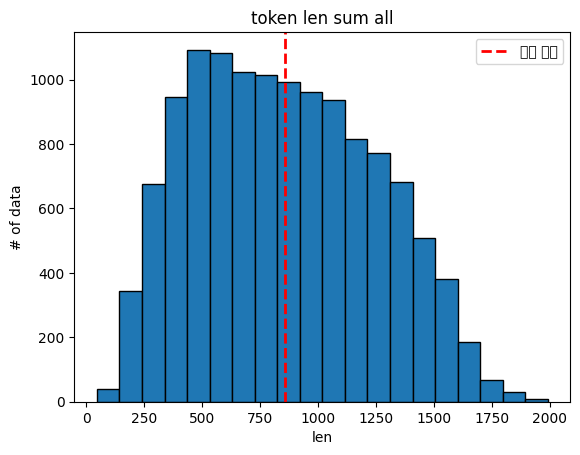

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns


#history_len_sum_per_q = [] #question당 history(Q+A) 토큰 길이 전체 합 [# of data]
#document_len_sum_per_q = [] #question당 document 토큰 길이 전체 합 [# of data]
#all_len_sum_per_q = [] #question당 전체 토큰 길이 합 [# of data]
#history_len_per_q = [] #question마다의 history 각 토큰들 개수  [# of data, # of history]
#document_len_per_q = [] #question마다의 document 각 토큰들 개수  [# of data, # of document]
#num_of_history = [] #question당 history 개수 [# of data]
#num_of_doc = [] #question당 document개수 [# of data]

all_len_sum_only_top3_document = []

cut_lenght_3 = []
cut_lenght_2 = []
cut_lenght_1 = []

remain_length_1 = []
remain_length_2 = []
remain_length_3 = []

for total_len, document_list in zip(all_len_sum_per_q, document_len_per_q):
    except_top_3_len = sum(sorted(document_list,reverse=True)[3:])
    cut_lenght_3.append(sum(sorted(document_list,reverse=True)[3:]))
    cut_lenght_2.append(sum(sorted(document_list,reverse=True)[2:]))
    cut_lenght_1.append(sum(sorted(document_list,reverse=True)[1:]))

    remain_length_1.append(sum(sorted(document_list,reverse=True)[:1]))
    remain_length_2.append(sum(sorted(document_list,reverse=True)[:2]))
    remain_length_3.append(sum(sorted(document_list,reverse=True)[:3]))
    
    all_len_sum_only_top3_document.append(total_len-except_top_3_len)

# 평균 길이 계산
average_length = sum(all_len_sum_only_top3_document) / len(all_len_sum_only_top3_document)

# 평균 길이를 갖는 수평선 추가
plt.axvline(average_length, color='r', linestyle='dashed', linewidth=2, label='평균 길이')

# 히스토그램으로 시각화
plt.hist(all_len_sum_only_top3_document, bins=20, edgecolor='black')
plt.xlabel('len')
plt.ylabel('# of data')
plt.title('token len sum all')

plt.legend()
plt.show()

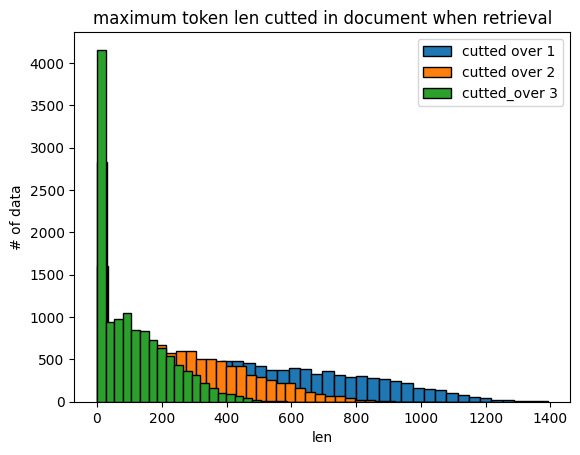

In [53]:
# 히스토그램으로 시각화
plt.hist(cut_lenght_1, bins=40, edgecolor='black', label="cutted over 1")
plt.hist(cut_lenght_2, bins=40, edgecolor='black', label="cutted over 2")
plt.hist(cut_lenght_3, bins=40, edgecolor='black', label="cutted_over 3")

plt.xlabel('len')
plt.ylabel('# of data')
plt.title('maximum token len cutted in document when retrieval')
#retrieval을 했을 때 최소로 잘려나가는 토큰의 개수
plt.legend()
plt.show()

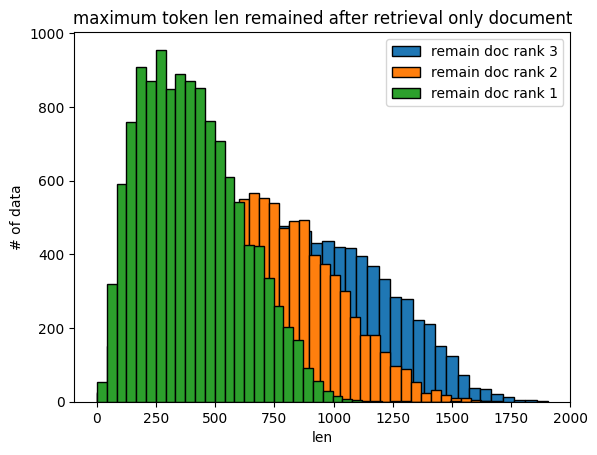

In [55]:
# 히스토그램으로 시각화
plt.hist(remain_length_3, bins=40, edgecolor='black', label="remain doc rank 3")
plt.hist(remain_length_2, bins=40, edgecolor='black', label="remain doc rank 2")
plt.hist(remain_length_1, bins=40, edgecolor='black', label="remain doc rank 1")

plt.xlabel('len')
plt.ylabel('# of data')
plt.title('maximum token len remained after retrieval only document')
#retrieval을 했을 때 최대로 남을 수 있는 document의 토큰 개수
plt.legend()
plt.show()

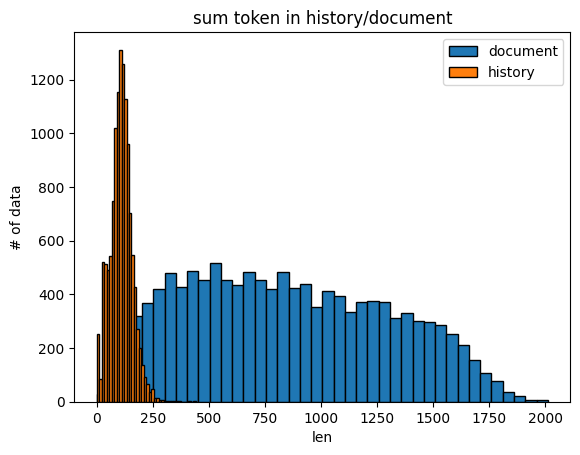

In [57]:
# 히스토그램으로 시각화
plt.hist(document_len_sum_per_q, bins=40, edgecolor='black', label="document")
plt.hist(history_len_sum_per_q, bins=40, edgecolor='black', label="history")

plt.xlabel('len')
plt.ylabel('# of data')
plt.title('sum token in history/document')
#history, document 각각 토큰 길이 합 계산시 지표
plt.legend()
plt.show()